In [16]:
import ssms
import lanfactory
import os
import numpy as np
from copy import deepcopy
import torch
import pickle

In [17]:
MODEL = "ddm"
RUN_SIMS = False
DEVICE = "cpu"

In [18]:
network_config_lan = pickle.load(open('../data/jax_models/' + MODEL + '/' + MODEL + '_jax_lan_network_config.pickle', 'rb'))
network_config_cpn = pickle.load(open('../data/jax_models/' + MODEL + '/' + MODEL + '_jax_cpn_network_config.pickle', 'rb'))

In [19]:
# LAN
jax_infer_lan = lanfactory.trainers.MLPJaxFactory(
                        network_config=network_config_lan,
                        train=False,
                        )

forward_lan, forward_jitted_lan = jax_infer_lan.make_forward_partial(
    seed=42,
    input_dim = ssms.config.model_config[MODEL]['n_params'] + 2,
    state = "../data/jax_models/" + MODEL + "/" + MODEL + "_jax_lan_train_state.jax",
    add_jitted = True
)

# # CPN
jax_infer_cpn = lanfactory.trainers.MLPJaxFactory(
    network_config=network_config_cpn,
    train=False,
)

forward_cpn, forward_jitted_cpn = jax_infer_cpn.make_forward_partial(
    seed=42,
    input_dim = ssms.config.model_config[MODEL]['n_params'],
    state = "../data/jax_models/" + MODEL + "/" + MODEL + "_jax_cpn_train_state.jax",
    add_jitted = True
)

passing through identity
passing through transform


In [20]:
# Plot LAN
import jax.numpy as jnp

# Test parameters:
theta = deepcopy(ssms.config.model_config[MODEL]['default_params'])

theta[0] = 0.2 # v
theta[3] = 1.0 # t

# Comparison simulator run
sim_out = ssms.basic_simulators.simulator.simulator(
    model=MODEL, theta=theta, n_samples=50000
)

# Make input metric
input_mat = jnp.zeros((2000, len(theta) + 2))
for i in range(len(theta)):
    input_mat = input_mat.at[:, i].set(jnp.ones(2000) * theta[i])

input_mat = input_mat.at[:, len(theta)].set(
    jnp.array(
        np.concatenate(
            [
                np.linspace(5, 0, 1000).astype(np.float32),
                np.linspace(0, 5, 1000).astype(np.float32),
            ]
        )
    )
)
input_mat = input_mat.at[:, len(theta) + 1].set(
    jnp.array(
        np.concatenate([np.repeat(-1.0, 1000), np.repeat(1.0, 1000)]).astype(np.float32)
    )
)

net_out = forward_jitted_lan(input_mat)

passing through identity


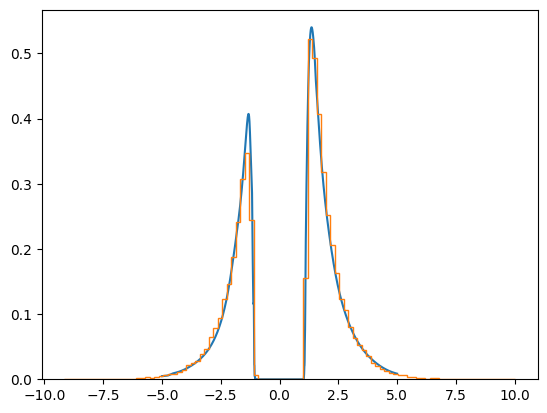

In [21]:
from matplotlib import pyplot as plt

plt.plot(np.linspace(-5, 5, 2000).astype(np.float32), np.exp(net_out))

plt.hist(
    sim_out["rts"] * sim_out["choices"],
    bins=100,
    histtype="step",
    fill=None,
    density=True,
);

In [22]:
# Plot CPN
# Test parameters:
# Test parameters:
theta = deepcopy(ssms.config.model_config[MODEL]['default_params'])

v = np.linspace(-3, 3, 50)

# Comparison simulator run
choice_p_list = []
for v_tmp in v:
    #print(v_tmp)
    theta[0] = v_tmp
    sim_out = ssms.basic_simulators.simulator.simulator(
        model=MODEL, theta=theta, n_samples=5000
    )
    choice_p_list.append(
        np.sum(sim_out["choices"] == -1.0) / sim_out["choices"].shape[0]
    )

    # NOTE: CPNs will be retrained to in fact give p of choice=1. That it's currently choice=-1
    # is an unintended consequence of some changes to the ssms training data generators (already fixed)

# Make input matric
# NOTE: This part is unnecessarily specialized to DDM
input_mat = jnp.zeros((50, 4))
input_mat = input_mat.at[:, 0].set(jnp.array(v))
input_mat = input_mat.at[:, 1].set(jnp.ones(50) * theta[1])
input_mat = input_mat.at[:, 2].set(jnp.ones(50) * theta[2])
input_mat = input_mat.at[:, 3].set(jnp.ones(50) * theta[3])

net_out = forward_jitted_cpn(input_mat)

passing through transform


Text(0.5, 0, 'v')

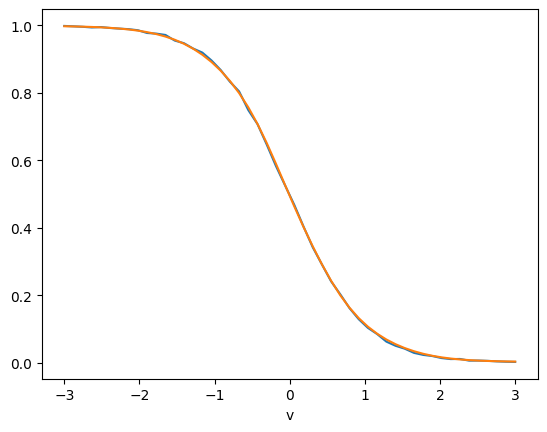

In [23]:
from matplotlib import pyplot as plt

plt.plot(input_mat.at[:, 0].set(jnp.array(v))[:, 0], choice_p_list)
plt.plot(input_mat.at[:, 0].set(jnp.array(v))[:, 0], np.exp(net_out))
plt.xlabel('v')